Transformer methods for Fake News Detection


 ** Transformer Architecture **

In [2]:
!pip install torch torchvision
!pip install transformers==2.2.0
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers==0.9.1

     |████████████████████████████████| 368kB 15.9MB/s 
     |████████████████████████████████| 890kB 57.3MB/s 
     |████████████████████████████████| 133kB 56.9MB/s 
     |████████████████████████████████| 1.2MB 38.8MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
     |████████████████████████████████| 7.2MB 55.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=effc054c1b5201ba9d3a4215dbc1fa5cac96f22be835421adf986b71e251ac77
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.56 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=8d1fc3d5dfc3a2b2f5b8852e2df77aa7107f9cb825e2d3a037a9e46589bec1ac
  Stored in direct

In [3]:
## Import required libraries
%matplotlib inline

import pandas as pd
import numpy as np

import gc
import requests
import os
import io
from google.colab import drive 
import datetime
from simpletransformers.classification import ClassificationModel

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn import preprocessing 

import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.7.0+cu101


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns
import re

In [4]:


## dataset-1

drive.mount('/content/gdrive')

train=pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/FNN/fnn_train.csv')
test=pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/FNN/fnn_test.csv')
print(train.head())
train_df = train[['statement', 'label_fnn']]
eval_df = test[['statement', 'label_fnn']]

train_df['statement'] = train_df['statement'].str.lower()
eval_df['statement'] = eval_df['statement'].str.lower()





Mounted at /content/gdrive
     id  ... label_fnn
0  3106  ...      fake
1  5655  ...      fake
2  3506  ...      fake
3  3450  ...      real
4  4776  ...      fake

[5 rows x 8 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
df_train = train_df[~train_df['statement'].isna()][['statement','label_fnn']]

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15212 entries, 0 to 15211
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  15212 non-null  object
 1   label_fnn  15212 non-null  object
dtypes: object(2)
memory usage: 356.5+ KB


In [7]:
df_train.drop_duplicates(subset=['statement'],keep='first',inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15204 entries, 0 to 15211
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  15204 non-null  object
 1   label_fnn  15204 non-null  object
dtypes: object(2)
memory usage: 356.3+ KB


In [20]:
label_encoder = preprocessing.LabelEncoder() 
df_train['label_fnn']= label_encoder.fit_transform(df_train['label_fnn'])
eval_df['label_fnn']= label_encoder.fit_transform(eval_df['label_fnn']) 

print(df_train.head())


                                           statement  label_fnn
0  a national organization says georgia has one o...          0
1  says barack obama s health care law  will be t...          0
2  says the southwest florida water management di...          0
3   the congressional budget office has this econ...          1
4  says the treasury department  says    percent ...          0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


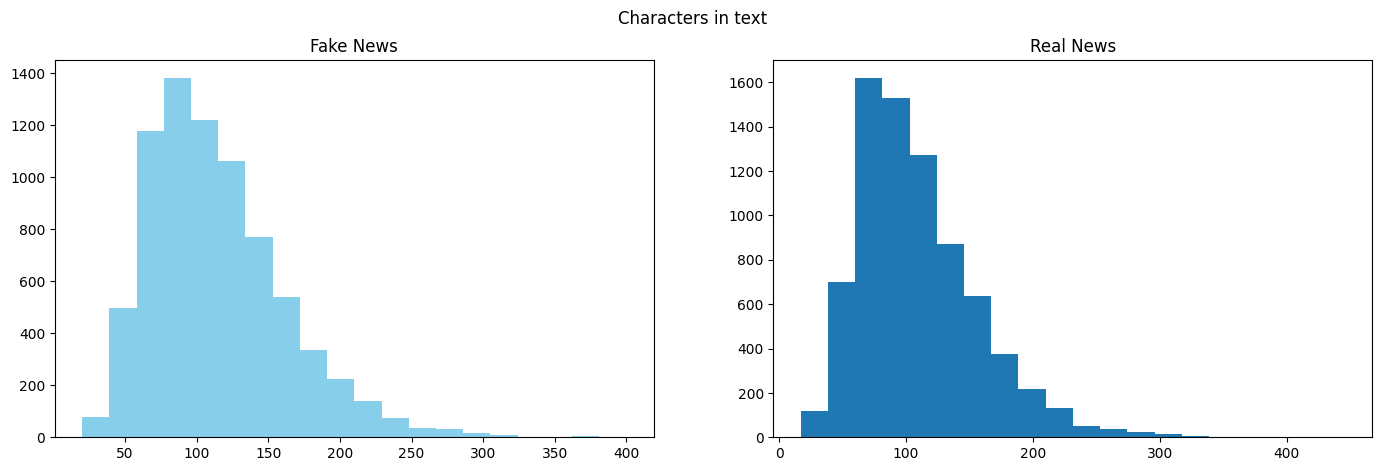

In [13]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=df_train[df_train["label_fnn"]==1]['statement'].str.len()
ax1.hist(length,bins = 20,color='skyblue')
ax1.set_title('Fake News')
length=df_train[df_train["label_fnn"]==0]['statement'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real News')
fig.suptitle('Characters in text')
plt.show()

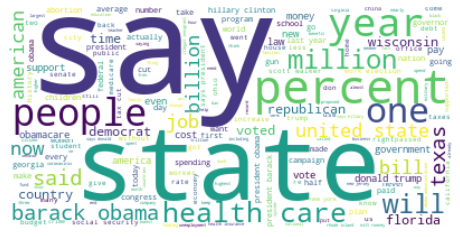

In [14]:
text = " ".join([x for x in df_train.statement])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

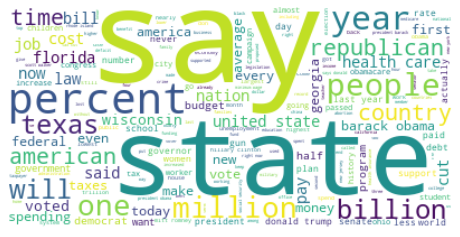

In [15]:
## for fake

text = " ".join([x for x in df_train.statement[df_train.label_fnn==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

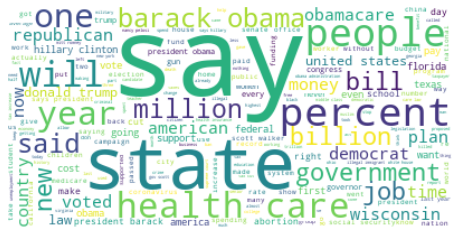

In [16]:
## for fake

text = " ".join([x for x in df_train.statement[df_train.label_fnn==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
print('Number of 0 (Not Fake) : ', df_train["label_fnn"].value_counts()[0])
print('Number of 1 (Fake) : ', df_train["label_fnn"].value_counts()[1])

Number of 0 (Not Fake) :  7616
Number of 1 (Fake) :  7588


In [18]:
# Dataset Preprocessing
def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

df_train['statement'] = df_train['statement'].apply(text_cleaning)

In [21]:
## for eval

eval_df['statement'] = eval_df['statement'].apply(text_cleaning)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
from simpletransformers.classification import ClassificationModel


# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, 
                            #args=args, use_cuda=True)
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True,'fp16': False},use_cuda=True)


In [40]:
start=datetime.datetime.now()
model.train_model(df_train)
end=datetime.datetime.now()

exec_time=end-start
print("execution time:", exec_time)


Converting to features started.


Running loss: 0.760080

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.934225

Training of bert model complete. Saved to outputs/.
execution time: 0:07:24.028337


In [41]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

Converting to features started.


In [42]:
print(result)
print(model_outputs)

{'mcc': 0.5515203819781449, 'tp': 376, 'tn': 399, 'fp': 19, 'fn': 260, 'eval_loss': 0.5339459658346393}
[[ 0.61607933 -0.9566794 ]
 [-0.5368289   0.1480243 ]
 [-0.8288346   0.48002288]
 ...
 [-0.3059481  -0.07171557]
 [-0.52669686  0.2964656 ]
 [-0.07311405 -0.2994163 ]]


In [43]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [44]:
true = eval_df['label_fnn'].tolist()
predicted = lst

In [45]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[399,  19],
       [260, 376]])

In [46]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['real','fake']))


              precision    recall  f1-score   support

        real       0.61      0.95      0.74       418
        fake       0.95      0.59      0.73       636

    accuracy                           0.74      1054
   macro avg       0.78      0.77      0.74      1054
weighted avg       0.81      0.74      0.73      1054

